## REDSEA python version 0.0.1

Translated from Yunhao Bai's MATLAB code by Bokai Zhu.

Some minor difference with Yunhao's MATLAB (subject to update in future version):

1. Does not filter the positive nuclear identity (cells) (because that part of code is in "mibisegmentByDeepProbWithPerm3.m"). But can be easily added by user.

2. Does not produce the sanity plot, since it should be outside of the compensation function. OPTIONAL add later

3. Does not produce FCS file at the end. Instead produce the 4 fcs file in a matrix style (pandas format), easier for later usage

In [30]:
# necessary packages
import PIL
from PIL import Image, ImageSequence, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
import skimage.measure
import skimage.morphology
import glob
import time
from matplotlib import rcParams
rcParams['figure.dpi']=200


from utils import imshow, side_by_side, plot_co_expression
from utils import intensity_change_at_cell_level
from SingleCellDataExtraction import MaskZstack

# helper function 1

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    return [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value

# helper function 2

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        

marker_oi = {'TNP_pilot_cycif': ['CD4','CD163','CD68','anti_CD3','CD20','CD8a'],
            'PilotTonsil_5_z08':['CD20', 'CD31', 'CD8', 'CD68', 'panCK']}

## Specify the sample and folders

In [53]:
SAMPLE = 'TNP_pilot_cycif'
# SAMPLE = 'PilotTonsil_5_z08'

# parameters for compensation
boundaryMod = 2 # 2 means boundary 
REDSEAChecker = 1 # 1 means subtract+ reinforce
elementShape = 2 # star, 1 == square size
elementSize = 2 # star or square extension size

# file locations
mainPath = f"data/{SAMPLE}" # main folder, redundant
massDS_path = f"{mainPath}/markers.csv" # csv file location, need
pathTiff = f"{mainPath}/registration" #  tiff location, need, should be single folder with multiple channels
pathMat = f"{mainPath}/segmentation/unmicst-{SAMPLE}/cellMask_subset.tif" 


SC_OUTPUT = f"data/{SAMPLE}/quantification"





SUBSET=True

add_string = ''
if SUBSET==True:
    add_string='_subset'

## Load and prep the marker file

In [32]:
# load the markers file
massDS = pd.read_csv(massDS_path) # read the mass csv
if SAMPLE == 'PilotTonsil_5_z08':
    massDS = pd.read_csv(massDS_path, header=None)
    massDS.columns = ['marker_name']

# remove the wavelenth
markers = []
for m in massDS.marker_name:
    for s in ['_488','_555','_570','_647', '_660']:
        m = m.replace(s,'') 
    markers.append(m)
massDS['marker_name'] = markers


clusterChannels = massDS['marker_name'] # only get the label column
clusterChannelsInds=np.where(np.isin(clusterChannels,massDS['marker_name']))[0] #channel indexes

##  Select which channels to use in REDSEA

In [33]:
normChannels = marker_oi[SAMPLE]
#### should be inside the function
normChannelsInds = ismember(normChannels,massDS['marker_name'])
channelNormIdentity = np.zeros((len(massDS['marker_name']),1))
# make a flag for compensation
for i in range(len(normChannelsInds)):
    channelNormIdentity[normChannelsInds[i]] = 1 

## Load multiplexed imaging data

In [34]:
# read the tiff file
tiff_fname = f'{pathTiff}/{SAMPLE}_subset.ome.tif'
tiff_img = imread(tiff_fname)

countsNoNoise = np.swapaxes(np.swapaxes(tiff_img, 0,1), 1,2)

countsNoNoise.shape

(200, 200, 36)

## Load the segmentation mask

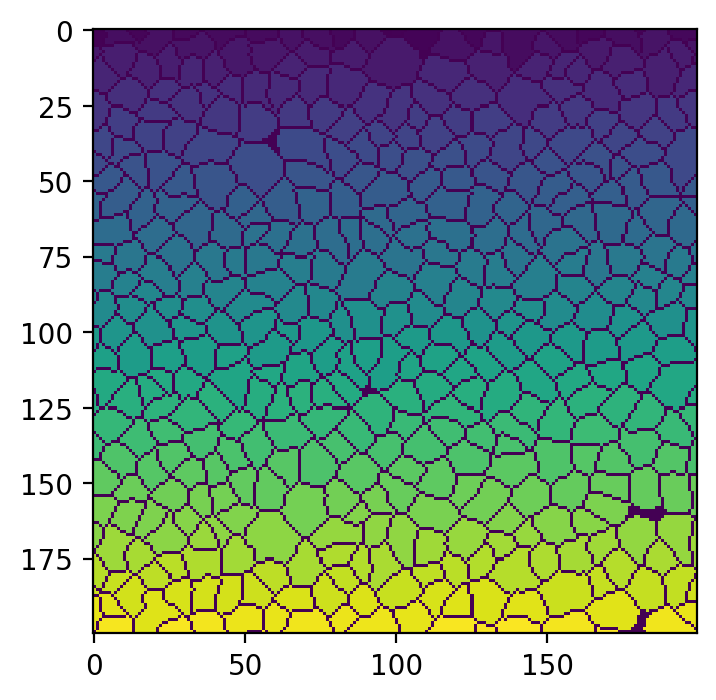

In [35]:
segMat = imread(pathMat)

# rename the labels as this is a subset from the full sample
lb = 0
for i in sorted(np.unique(segMat)):
    segMat = np.where(segMat == i, lb, segMat)
    lb+=1
    
labelNum = np.max(segMat)
stats = skimage.measure.regionprops(segMat)
newLmod = segMat

##### stuff related to mat finisehd
channelNum = len(clusterChannels) # how many channels
plt.imshow(segMat)

## REDSEA

In [36]:
### make empty container matrices

data = np.zeros((labelNum,channelNum))
dataScaleSize = np.zeros((labelNum,channelNum))
cellSizes = np.zeros((labelNum,1))

In [37]:
# this part extract counts data from the whole cell regions, for each individual cells etc
centroid_xs = []
centroid_ys = []


for i in range(labelNum): # for each cell (label)
    label_counts=[countsNoNoise[coord[0],coord[1],:] for coord in stats[i].coords] # all channel count for this cell
    data[i,0:channelNum] = np.sum(label_counts, axis=0) #  sum the counts for this cell
    dataScaleSize[i,0:channelNum] = np.sum(label_counts, axis=0) / stats[i].area # scaled by size
    cellSizes[i] = stats[i].area # cell sizes
    centroid_xs.append(stats[i].centroid[0])
    centroid_ys.append(stats[i].centroid[1])

In [38]:
# now we start the boundary compensation part
# part of code in MATLAB function:
# MIBIboundary_compensation_boundarySA(newLmod,data,countsNoNoise,channelNormIdentity,elementShape,elementSize,REDSEAChecker)

# this block is for computing cell cell matrix

# what it needs 1 newLmod (segmentation mask matrix)
# countsNoNoiseoise (counts matrix, row, col, channel)
# normIdentity (plots, leave out for now)
# elmentshape, elementsize
# REDSEAChecker: subtract, reinforce selection

[rowNum, colNum] = newLmod.shape
cellNum=labelNum
cellPairMap = np.zeros((cellNum,cellNum)) # cell-cell shared perimeter matrix container

## need to add border to the segmentation mask (newLmod in this case)
newLmod_border = np.pad(newLmod, pad_width=1, mode='constant', constant_values=0)

# start looping the mask and produce the cell-cell contact matrix
for i in range(rowNum):
    for j in range(colNum):
        if newLmod[i,j] == 0:
            tempMatrix = newLmod_border[i:i+3,j:j+3] # the 3x3 window, xy shifted +1 due to border
            tempFactors = np.unique(tempMatrix) #unique
            tempFactors = tempFactors-1 # minus one for python index
            if len(tempFactors)==3: # means only two cells
                cellPairMap[tempFactors[1],tempFactors[2]] = cellPairMap[tempFactors[1],tempFactors[2]]+1 # count zero
            elif len(tempFactors)==4: # means three cells, three pairs
                cellPairMap[tempFactors[1],tempFactors[2]] = cellPairMap[tempFactors[1],tempFactors[2]]+1 # count zero
                cellPairMap[tempFactors[1],tempFactors[3]] = cellPairMap[tempFactors[1],tempFactors[3]]+1 # count zero
                cellPairMap[tempFactors[2],tempFactors[3]] = cellPairMap[tempFactors[2],tempFactors[3]]+1 # count zero
            elif len(tempFactors)==5: # means four cells, 6 pairs
                cellPairMap[tempFactors[1],tempFactors[2]] = cellPairMap[tempFactors[1],tempFactors[2]]+1 # count zero
                cellPairMap[tempFactors[1],tempFactors[3]] = cellPairMap[tempFactors[1],tempFactors[3]]+1 # count zero
                cellPairMap[tempFactors[1],tempFactors[4]] = cellPairMap[tempFactors[1],tempFactors[4]]+1 # count zero
                
                cellPairMap[tempFactors[2],tempFactors[3]] = cellPairMap[tempFactors[2],tempFactors[3]]+1 # count zero
                cellPairMap[tempFactors[2],tempFactors[4]] = cellPairMap[tempFactors[2],tempFactors[4]]+1 # count zero
                
                cellPairMap[tempFactors[3],tempFactors[4]] = cellPairMap[tempFactors[3],tempFactors[4]]+1 # count zero

In [39]:
# formatting of the cell cell maps

# double direction
cellPairMap = cellPairMap + np.transpose(cellPairMap)

###############
cellBoundaryTotal = np.sum(cellPairMap,axis=0) # count the boundary
############### this step might cause error in ark version, double check with YH

# devide to get fraction
cellBoundaryTotalMatrix = np.tile(cellBoundaryTotal,(cellNum,1))
#cellBoundaryTotalMatrix = repmat(cellBoundaryTotal',[1 cellNum]);
cellPairNorm = REDSEAChecker*np.identity(cellNum) - cellPairMap/cellBoundaryTotalMatrix
cellPairNorm = np.transpose(cellPairNorm) ### this is a werid bug in python, need to transpose
# now starts the calculation of signals from pixels along the boudnary of cells
MIBIdataNearEdge1 = np.zeros((cellNum,channelNum))

In [40]:
# start the boundary region selection and count extraction

##### A List of Items
items = list(range(cellNum))
l = len(items)
printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50) # progress bar
#####

######pre-calculated shape
if elementShape==1: # square
    square=skimage.morphology.square(2*elementSize+1)
    square_loc=np.where(square==1)
elif elementShape==2: # diamond
    diam=skimage.morphology.diamond(elementSize) # create diamond shapte based on elementSize
    diam_loc=np.where(diam==1)
else:
    print("Error elementShape Value not recognized.")
############

for i in range(cellNum):
    label=i+1 # python problem
    [tempRow,tempCol] = np.where(newLmod==label)
    # sequence in row not col, should not affect the code
    for j in range(len(tempRow)):
        label_in_shape=[] # empy list in case
        # make sure not expand outside
        if (elementSize-1<tempRow[j]) and (tempRow[j]<rowNum-elementSize-2) and (elementSize-1<tempCol[j]) and (tempCol[j]<colNum-elementSize-2):
            ini_point = [tempRow[j]-elementSize,tempCol[j]-elementSize] # corrected top-left point
        
            if elementShape==1: # square
                square_loc_ini_x=[item + ini_point[0] for item in square_loc[0]]
                square_loc_ini_y=[item + ini_point[1] for item in square_loc[1]]
                
                label_in_shape=[newLmod[square_loc_ini_x[k],square_loc_ini_y[k]] for k in range(len(square_loc_ini_x))]
                
            elif elementShape==2: # diamond
                diam_loc_ini_x=[item + ini_point[0] for item in diam_loc[0]]
                diam_loc_ini_y=[item + ini_point[1] for item in diam_loc[1]]
                # finish add to ini point
            
                label_in_shape=[newLmod[diam_loc_ini_x[k],diam_loc_ini_y[k]] for k in range(len(diam_loc_ini_x))]
            
        if 0 in label_in_shape:
            MIBIdataNearEdge1[i,:] = MIBIdataNearEdge1[i,:] + countsNoNoise[tempRow[j],tempCol[j],:]
    
    # Update Progress Bar
    printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [41]:
## fome final formatting

MIBIdataNorm2 = np.transpose(np.dot(np.transpose(MIBIdataNearEdge1),cellPairNorm))
#this is boundary signal subtracted by cell neighboor boundary
MIBIdataNorm2 = MIBIdataNorm2 + data # reinforce onto the whole cell signal (original signal)
MIBIdataNorm2[MIBIdataNorm2<0] = 0 # clear out the negative ones
# flip the channelNormIdentity for calculation
rev_channelNormIdentity=np.ones_like(channelNormIdentity)-channelNormIdentity
# composite the normalized channels with non-normalized channels
# MIBIdataNorm2 is the matrix to return
MIBIdataNorm2 = data * np.transpose(np.tile(rev_channelNormIdentity,(1,cellNum))) + MIBIdataNorm2 * np.transpose(np.tile(channelNormIdentity,(1,cellNum)))
# scale by size
dataCompenScaleSize = MIBIdataNorm2 / cellSizes
# some last steps
############ SKIP THE POSITIVE NUCLEAR IDENTITY FILTER
############ SHOULD ADD by user's choice

labelIdentityNew2=np.ones(cellNum) ####### this part is the skipped line
sumDataScaleSizeInClusterChannels = np.sum(dataScaleSize[:,clusterChannelsInds],axis=1) # add all the cluster channels
labelIdentityNew2[sumDataScaleSizeInClusterChannels<0.1] = 2 # remove the cells that does not have info in cluster channels
# the function should return 4 varaibles
# matrix 
dataCells = data[labelIdentityNew2==1,:]
dataScaleSizeCells = dataScaleSize[labelIdentityNew2==1,:]
dataCompenCells = MIBIdataNorm2[labelIdentityNew2==1,:]
dataCompenScaleSizeCells = dataCompenScaleSize[labelIdentityNew2==1,:]


In [42]:
# create the final matrixs ( 4 types of them)

labelVec = np.where(labelIdentityNew2==1)
labelVec = [item + 1 for item in labelVec ] # python indexing difference need to add 1

# get cell sizes
cellSizesVec = cellSizes[labelIdentityNew2==1].flatten()

# produce the matrices

## first dataframe
dataL = pd.DataFrame({'CellID':labelVec[0].tolist(), 'cell_size':cellSizesVec})
dataCells_df=pd.DataFrame(dataCells)
dataCells_df.columns = clusterChannels
dataL_full = pd.concat((dataL,dataCells_df),axis=1)
### second
dataScaleSizeL_df=pd.DataFrame(dataScaleSizeCells)
dataScaleSizeL_df.columns = clusterChannels
dataScaleSizeL_full = pd.concat((dataL,dataScaleSizeL_df),axis=1)
### third
dataCompenL_df=pd.DataFrame(dataCompenCells)
dataCompenL_df.columns = clusterChannels
dataCompenL_full = pd.concat((dataL,dataCompenL_df),axis=1)
### forth
dataCompenScaleSizeL_df=pd.DataFrame(dataCompenScaleSizeCells)
dataCompenScaleSizeL_df.columns = clusterChannels
dataCompenScaleSizeL_full = pd.concat((dataL,dataCompenScaleSizeL_df),axis=1)


for d in [dataL_full, dataScaleSizeL_full, dataCompenL_full, dataCompenScaleSizeL_full]:
    d['x_centroid'] = centroid_xs
    d['y_centroid'] = centroid_ys

In [43]:
dataScaleSizeL_full.head() # orignal counts extracted from tiff files, but scaled by cell size

,CellID,cell_size,Hoechst1,A488,A555,A647,Hoechst2,anti_NaKATPase,anti_CD3,anti_CD45RO,...,Hoechst8,Ecad,Vimentin,Catenin,Hoechst9,LaminAC,pH3,H2ax,x_centroid,y_centroid
0,1,3.0,5513.666667,2159.000000,538.000000,1124.000000,7420.000000,7660.666667,5394.666667,25428.666667,...,11579.666667,1186.000000,1874.000000,1576.333333,19753.333333,1594.666667,435.666667,1162.000000,0.333333,96.666667
1,2,7.0,4083.714286,1996.285714,483.571429,1066.857143,5107.857143,6688.857143,4307.571429,20203.142857,...,7230.142857,1062.857143,3300.285714,1538.000000,13574.714286,1563.428571,393.000000,1133.857143,0.428571,100.285714
2,3,18.0,13183.722222,2117.333333,441.722222,1240.111111,16178.944444,5435.666667,8759.111111,8317.500000,...,29443.000000,1031.000000,817.111111,1190.166667,53230.833333,2036.722222,502.666667,1053.944444,2.111111,1.277778
3,4,60.0,9018.966667,1941.000000,495.066667,1018.966667,13933.500000,5574.733333,5465.466667,7841.683333,...,17065.783333,1021.800000,1426.216667,1612.300000,28540.750000,1843.666667,446.500000,1138.300000,2.383333,108.433333
4,5,2.0,10859.500000,1922.500000,506.000000,1081.500000,13954.500000,3910.000000,14962.500000,12157.500000,...,23767.000000,1018.500000,1535.500000,952.000000,49755.500000,2082.000000,480.500000,1250.500000,0.000000,180.500000


In [44]:
dataCompenScaleSizeL_full.head() # redsea compensated counts, but scaled by cell size

,CellID,cell_size,Hoechst1,A488,A555,A647,Hoechst2,anti_NaKATPase,anti_CD3,anti_CD45RO,...,Hoechst8,Ecad,Vimentin,Catenin,Hoechst9,LaminAC,pH3,H2ax,x_centroid,y_centroid
0,1,3.0,5513.666667,2159.000000,538.000000,1124.000000,7420.000000,7660.666667,0.000000,25428.666667,...,11579.666667,1186.000000,1874.000000,1576.333333,19753.333333,1594.666667,435.666667,1162.000000,0.333333,96.666667
1,2,7.0,4083.714286,1996.285714,483.571429,1066.857143,5107.857143,6688.857143,0.000000,20203.142857,...,7230.142857,1062.857143,3300.285714,1538.000000,13574.714286,1563.428571,393.000000,1133.857143,0.428571,100.285714
2,3,18.0,13183.722222,2117.333333,441.722222,1240.111111,16178.944444,5435.666667,7355.451278,8317.500000,...,29443.000000,1031.000000,817.111111,1190.166667,53230.833333,2036.722222,502.666667,1053.944444,2.111111,1.277778
3,4,60.0,9018.966667,1941.000000,495.066667,1018.966667,13933.500000,5574.733333,4833.412541,7841.683333,...,17065.783333,1021.800000,1426.216667,1612.300000,28540.750000,1843.666667,446.500000,1138.300000,2.383333,108.433333
4,5,2.0,10859.500000,1922.500000,506.000000,1081.500000,13954.500000,3910.000000,0.000000,12157.500000,...,23767.000000,1018.500000,1535.500000,952.000000,49755.500000,2082.000000,480.500000,1250.500000,0.000000,180.500000


In [55]:
dataScaleSizeL_full.to_csv(f"{SC_OUTPUT}/single_cell_before_redsea_{SAMPLE}{add_string}.csv")
dataCompenScaleSizeL_full.to_csv(f"{SC_OUTPUT}/single_cell_after_redsea_{SAMPLE}{add_string}.csv")

# Futhure analysis

## Create original dataframe (marker expression at cell level) -- later realized this is already a output from REDSEA.

In [45]:
# specify variables to feed
channel_names_loaded = markers
masks_loaded = {'whole-cell':segMat}

# extract single-cell data for multiple channels for multiple masks
data_original = MaskZstack(masks_loaded,tiff_fname,channel_names_loaded,intensity_props=["mean_intensity"])['whole-cell']
data_original.head()

finished !


,CellID,Hoechst1,A488,A555,A647,Hoechst2,anti_NaKATPase,anti_CD3,anti_CD45RO,Hoechst3,...,H2ax,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,1,5513.666667,2159.000000,538.000000,1124.000000,7420.000000,7660.666667,5394.666667,25428.666667,5933.000000,...,1162.000000,96.666667,0.333333,3,2.309401,1.333333,0.816497,1.000000,0.750000,-0.785398
1,2,4083.714286,1996.285714,483.571429,1066.857143,5107.857143,6688.857143,4307.571429,20203.142857,4140.428571,...,1133.857143,100.285714,0.428571,7,4.155375,1.905471,0.888666,1.000000,0.875000,-1.425068
2,3,13183.722222,2117.333333,441.722222,1240.111111,16178.944444,5435.666667,8759.111111,8317.500000,17876.833333,...,1053.944444,1.277778,2.111111,18,5.946927,3.955553,0.746717,0.900000,0.750000,0.020039
3,4,9018.966667,1941.000000,495.066667,1018.966667,13933.500000,5574.733333,5465.466667,7841.683333,11372.016667,...,1138.300000,108.433333,2.383333,60,11.346041,7.121221,0.778504,0.967742,0.714286,1.563846
4,5,10859.500000,1922.500000,506.000000,1081.500000,13954.500000,3910.000000,14962.500000,12157.500000,15132.000000,...,1250.500000,180.500000,0.000000,2,2.000000,0.000000,1.000000,1.000000,1.000000,1.570796


## Expression change at cell level, before and after REDSEA

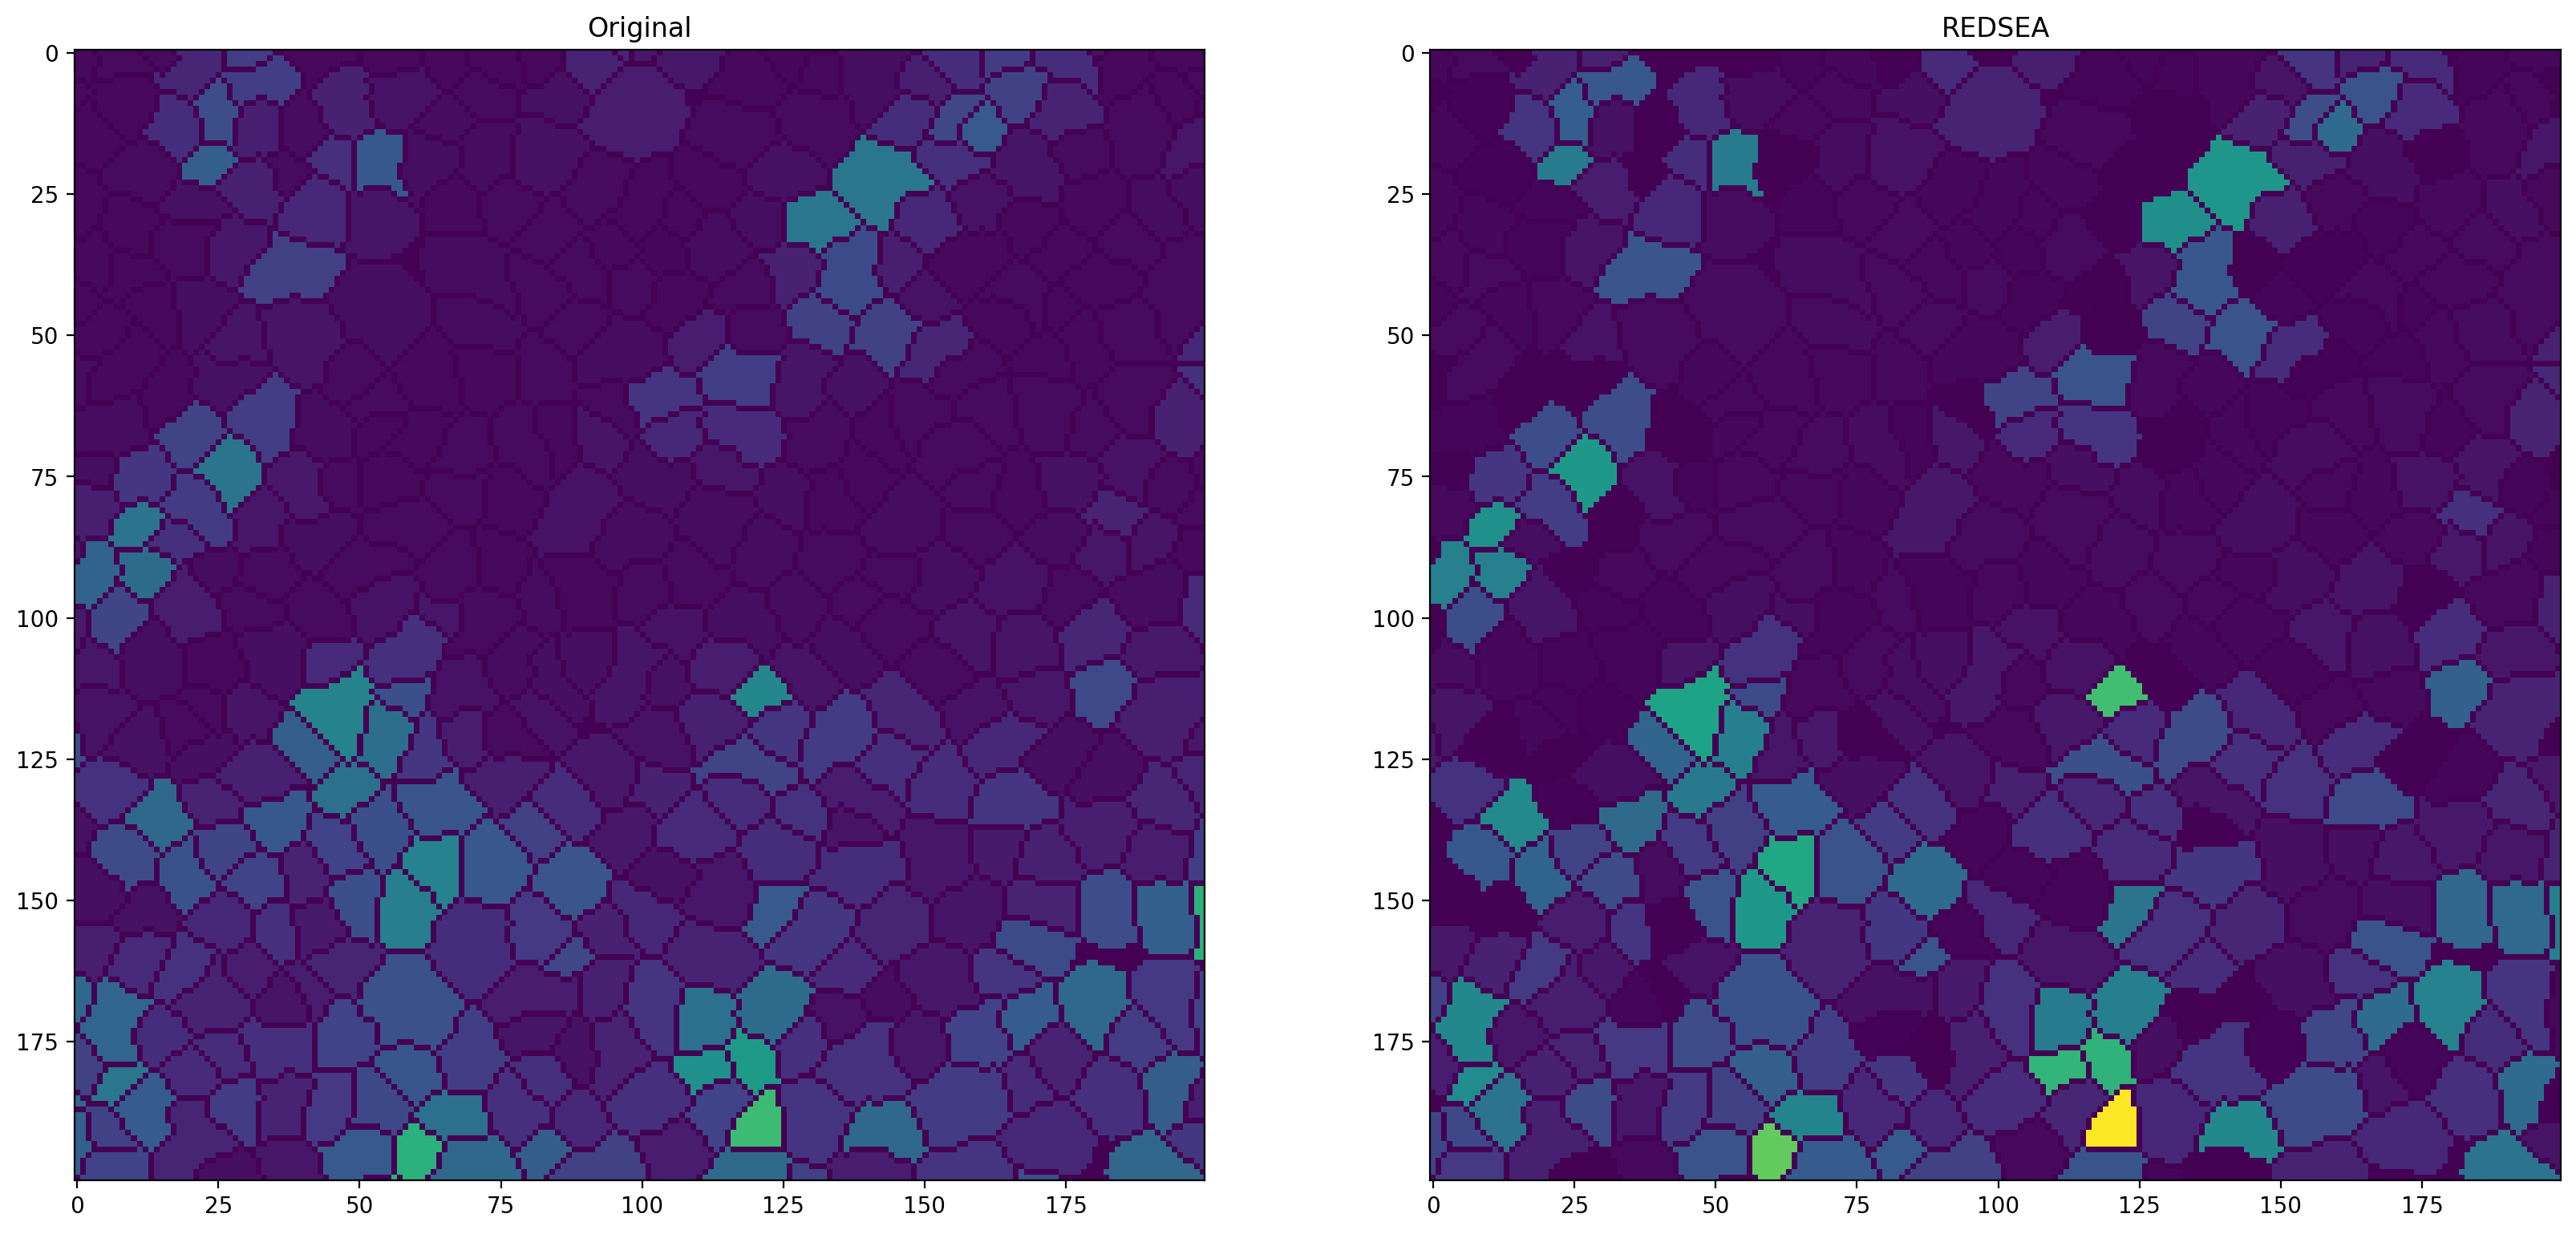

In [48]:
df_before = dataScaleSizeL_full.copy()
seg_mask = segMat.copy()
marker = 'CD20'

df_after = dataCompenScaleSizeL_full.copy()
seg_1, seg_2 = intensity_change_at_cell_level(df_before, df_after, seg_mask, marker)
side_by_side(seg_1, seg_2, (20,10), 'Original','REDSEA', same_vlim=True, resize=False)

## Diagnose with co-expression plot

In [26]:
# This markers pairs were obtained by Clemens Hug from LSP

mutualy_exclusive_pairs = [('anti_CD3', 'CD20'),
                          ('CD8a', 'CD4'),
                          ('CD20','CD68'),
                          ('CD8a', 'FOXP3'),
                          ('CD45', 'Keratin')]


=== anti_CD3 vs. CD20
before REDSEA


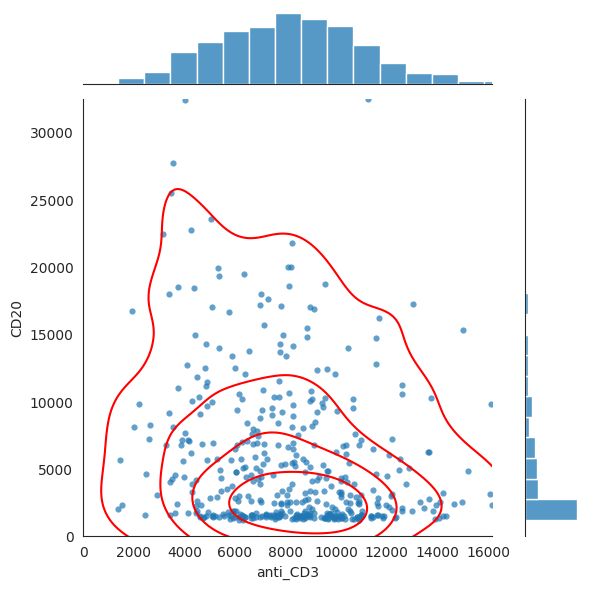

after REDSEA


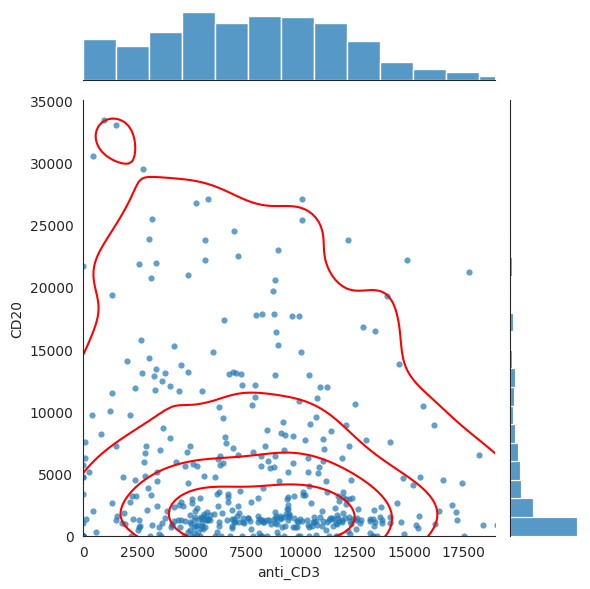


=== CD8a vs. CD4
before REDSEA


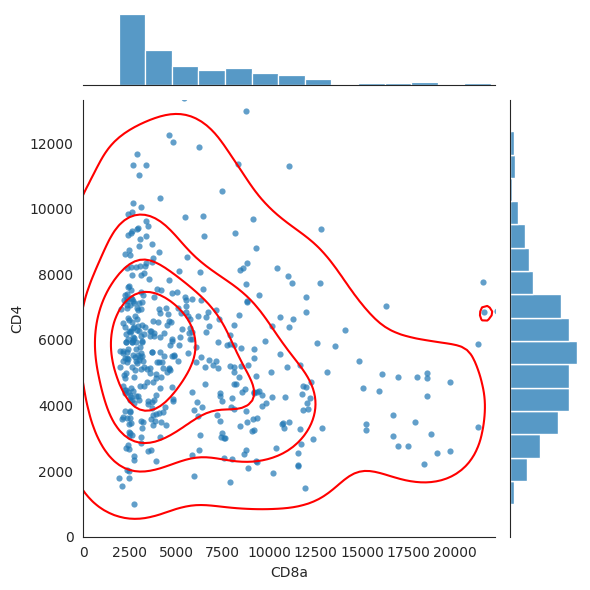

after REDSEA


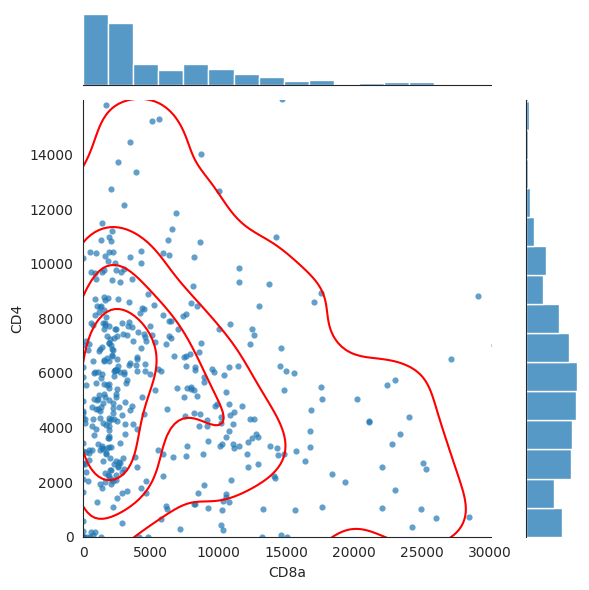


=== CD20 vs. CD68
before REDSEA


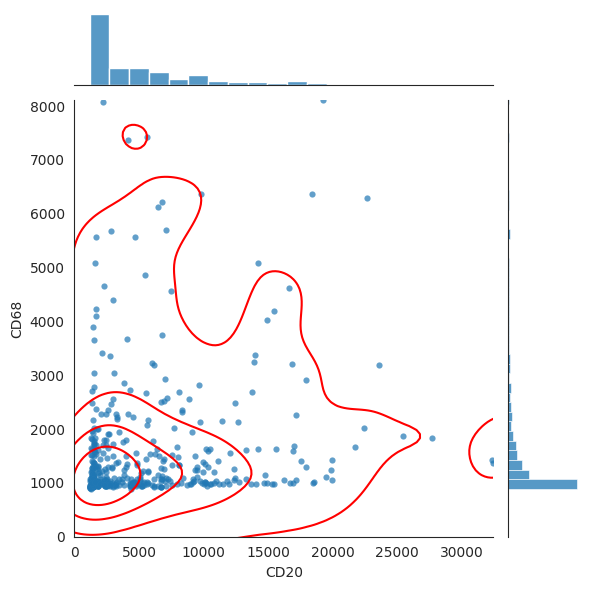

after REDSEA


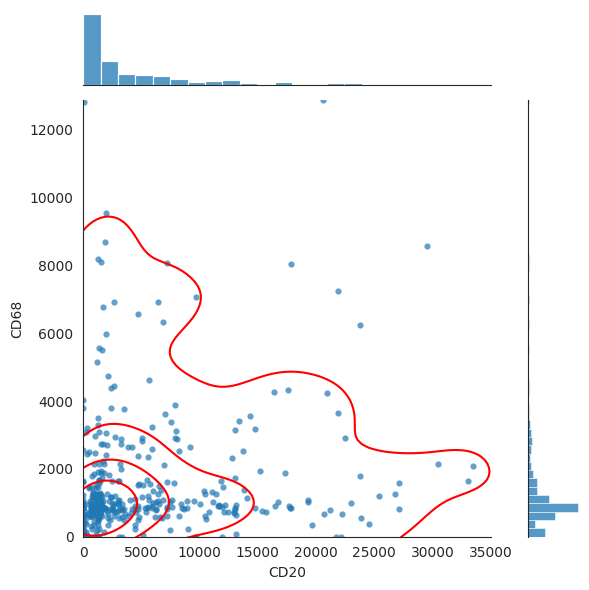


=== CD8a vs. FOXP3
before REDSEA


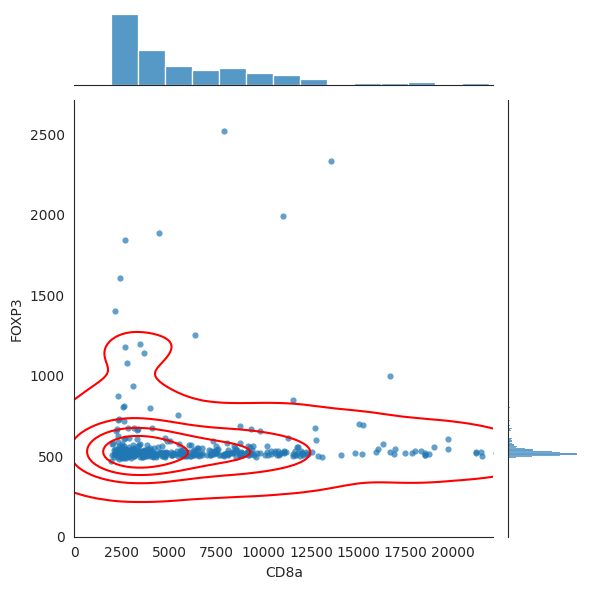

after REDSEA


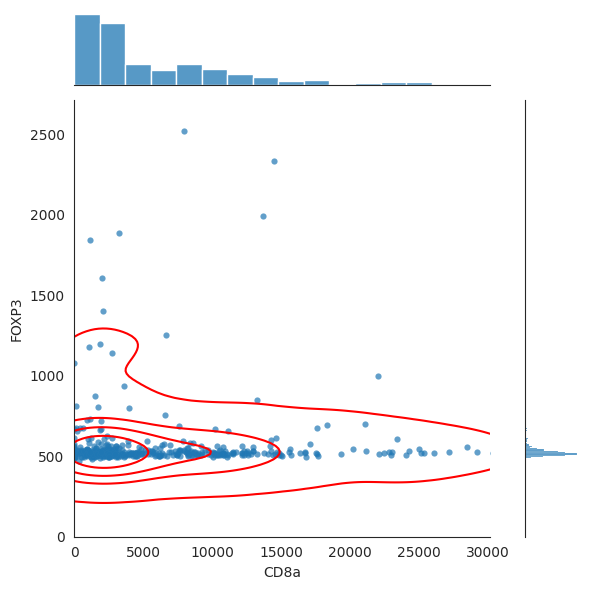


=== CD45 vs. Keratin
before REDSEA


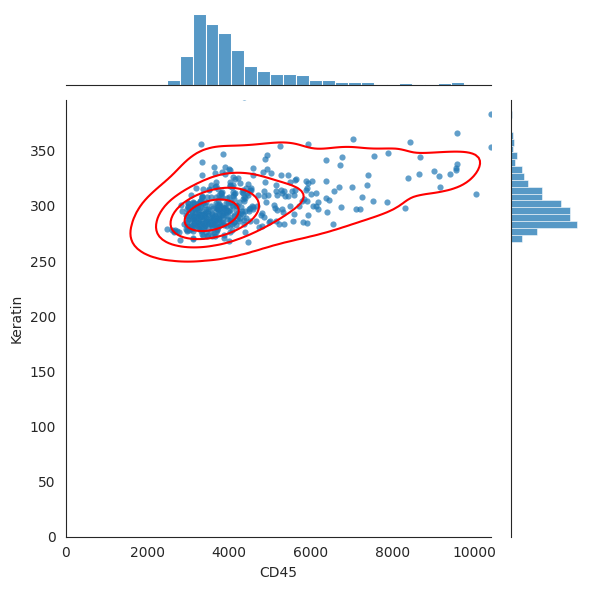

after REDSEA


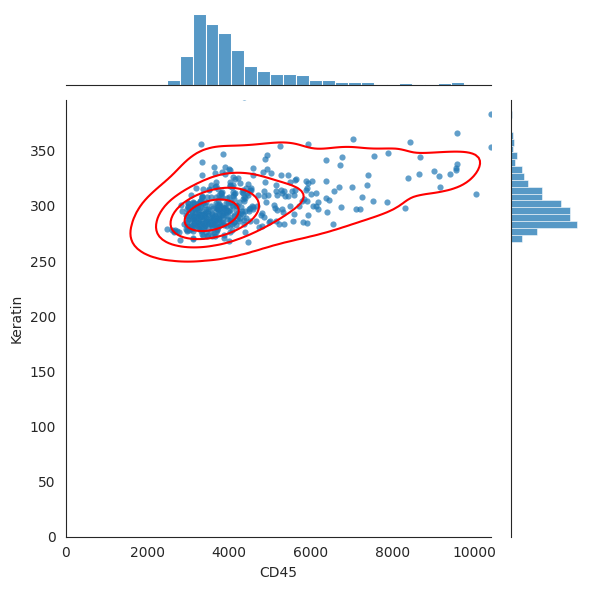

In [28]:
rcParams['figure.dpi']=100

for pair in mutualy_exclusive_pairs:
    marker_1 = pair[0]
    marker_2 = pair[1]    
    print ('\n===',marker_1,'vs.', marker_2)
    print ('before REDSEA')
    plot_co_expression(df_before, marker_1, marker_2)
    print ('after REDSEA')           
    plot_co_expression(df_after, marker_1, marker_2)